In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import sympy as sp
from tqdm import tqdm
from scipy.optimize import minimize
from IPython.display import clear_output
import pandas as pd
import time
import matplotlib.pyplot as plt
from PIL import Image
import io

In [2]:
M = 1
rmaching = 3
def drdrho(rho, r, w):
    beta = - np.angle(w)
    return np.exp(1j*beta)*(1-2*M/r)

def Q(r, w, l, s):
    return w**2 - (1 - 2*M/r)*(l*(l+1)/r**2 + 2*M*(1-s**2)/r**3)

def dPdrho(rho, pos, w, l, s, interp):
    beta = -np.angle(w)
    QA = Q(interp(rho), w, l, s)
    return -np.exp(1j*beta)*(pos[0]**2 + QA)

def dPtildrho(rho, pos, w, l, s, interp):
    beta = -np.angle(w)
    QA = Q(interp(rho), w, l, s)
    rmaching = 3*M
    theta = pos[0] + abs(w)*rho + w*(rmaching+2*np.log(rmaching/(2*M) - 1))
    
    return -np.exp(1j*beta)*(w-QA/w)*np.sin(theta)**2

def dHdrho(rho, pos, w, l, s, interp):
    beta = - np.angle(w)
    QA = Q(interp(rho), w, l, s)
    return -2*(pos[0]*pos[1] + w)*np.exp(1j*beta)

def dHtildrho(rho, pos, w, l, s, interp):
    beta = - np.angle(w)
    QA = Q(interp(rho), w, l, s)
    rmaching = 3*M
    rs = (rmaching+2*np.log(rmaching/(2*M) - 1)) + rho*np.exp(1j*beta)
    PP = w*np.tan(np.pi/2 - pos[0] - w*rs)
    return -2*(PP*pos[1] + w)*np.exp(1j*beta)

def dItildrho(rho, pos, w, l, s, interp):
    beta = - np.angle(w)
    rs = (rmaching+2*np.log(rmaching/(2*M) - 1)) + rho*np.exp(1j*beta)
    PP = w*np.tan(np.pi/2 - pos[0] - w*rs)
    return np.exp(1j*beta)*PP

def F_left_ma(rho, pos, w, l, s, interp):
    DP = dPdrho(rho, pos, w, l, s, interp)
    DH = dHdrho(rho, pos, w, l, s, interp)
    return np.array([DP,DH])

def F_right_ma(rho, pos, w, l, s, interp):
    DP = dPtildrho(rho, pos, w, l, s, interp)
    DH = dHtildrho(rho, pos, w, l, s, interp)
    DI = dItildrho(rho, pos, w, l, s, interp)
    return np.array([DP,DH,DI])

def solver(rho, diff_func, IC, w, l, s, interp):
    solution = np.zeros((len(rho),len(IC)), dtype = np.complex128)
    solution[0] = IC
    dt = np.diff(rho)
    for i in tqdm(range(1, len(rho))):
        k1 = diff_func(rho[i-1], solution[i-1], w, l, s, interp)*dt[i-1]
        k2 = dt[i-1]*diff_func(rho[i-1]+dt[i-1]/2,solution[i-1]+k1/2, w, l, s, interp)
        k3 = dt[i-1]*diff_func(rho[i-1]+dt[i-1]/2,solution[i-1]+k2/2, w, l, s, interp)
        k4 = dt[i-1]*diff_func(rho[i-1]+dt[i-1],solution[i-1]+k3, w, l, s, interp)
        
        solution[i] = solution[i-1] +(1/6)*(k1+2*k2+2*k3+k4)
    return solution

def to_prufer(P, rho, w):
    beta = - np.angle(w)
    return -w*(rmaching + 2*np.log(rmaching/(2*M) - 1) + rho*np.exp(1j*beta))-0.5j*np.log((1j*P-w)/(1j*P+w))

def from_prufer(Pt, rho, w):
    beta = np.angle(w)
    PPP = np.zeros(len(Pt), dtype=np.complex128)
    for i in range(len(Pt)):
        rs = (rmaching + 2*np.log(rmaching/(2*M) - 1) + rho[i]*np.exp(1j*beta))
        A = np.exp(2j*(w*rs+Pt[i]))
        PPP[i] = 1j*w*(A+1)/(A-1)
    return PPP
def d2Qdr(r, l, s):
    f = 1-2*M/r
    V = f*(l*(l+1)/r**2 + 2*M*(1-s**2)/r**3)
    A1 = (6*V/r**2)*(2*M/(f*r) - 1)
    A2 = (4*M*(1-s**2)/r**5)
    A3 = 2/r - 3*f
    return A1 + A2*A3

def rma(l, s):
    sigma = (s**2-1)
    L = l*(l+1)
    A = 3/2*(1+sigma/L)
    B = L*(9*l**2 + 14) + 9*l**2 + s**2*(9*(sigma-1)-14*L)
    return A + np.sqrt(B)/(2*L)

In [3]:
rho_min = -50*M
rho_max = 250*M

In [4]:
def QNM_search(ww, l, s):
    start_time = time.time()
    w = ww[0] + ww[1]*1j
    rmaching = 3#rma(l,s)
    
    r_sol_left = solve_ivp(drdrho, [0, rho_min], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", rtol = 1e-10, atol = 1e-10)
    
    r_sol_right = solve_ivp(drdrho, [0, rho_max], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", rtol = 1e-10, atol = 1e-10)
    r_left = r_sol_left.y[0][::-1]
    rho_left = r_sol_left.t[::-1]

    r_right = r_sol_right.y[0][::-1]
    rho_right = r_sol_right.t[::-1]
    
    left_r_rho_interp = interp1d(rho_left, r_left, kind='cubic')
    right_r_rho_interp = interp1d(rho_right, r_right, kind='cubic')
    
    r_time = time.time()
    
    print(f"Time for coordinate array: {r_time-start_time}")
    
    PP_0 = 1j*np.sqrt(Q(right_r_rho_interp(rho_max), w, l, s))
    IC_PP = to_prufer(PP_0, rho_max, w)
    IC_PL = -1j*np.sqrt(Q(left_r_rho_interp(rho_min), w, l, s))
    
    PP = solve_ivp(F_right_ma, [rho_right[0], rho_right[-1]], np.array([IC_PP,0,0]), args=(w,l,s,right_r_rho_interp), method="DOP853", t_eval=rho_right,rtol = 1e-10, atol = 1e-10).y[0][-1]
    PL = solve_ivp(F_left_ma, [rho_left[0], rho_left[-1]], np.array([IC_PL,0]), args=(w,l,s,left_r_rho_interp), method="DOP853", t_eval=rho_left, rtol = 1e-10, atol = 1e-10).y[0][-1]
    P_time = time.time()
    
    print(f"phase calc time: {P_time-r_time}")
    
    rs = (rmaching + 2*np.log(rmaching/(2*M) - 1))
    A = np.exp(2j*(w*rs+PP))
    PP = 1j*w*(A+1)/(A-1)
    
    PtP_time = time.time()
    print(f"Pruffer transform time: {PtP_time-P_time}")
    
    print(f"Done:{w}", end="\r")
    clear_output(wait=True)
    return abs(PP-PL)

In [5]:
w_start = [0.38, -0.09, 2, 2]

path = []

def save(wi):
    global path
    path = np.append(path,wi)

w_s2_l2_n0 = minimize(QNM_search, np.array([w_start[0],w_start[1]]), args = (w_start[2],w_start[3],), method="Nelder-Mead", tol=1e-7, callback=save)
path = np.append([0.4, -0.1],path)
path = path.reshape((int(len(path)/2),2))

Time for coordinate array: 0.010069847106933594
phase calc time: 0.37206101417541504
Pruffer transform time: 7.390975952148438e-05


In [6]:
def sol(w, l, s):
    beta = - np.angle(w)
    # Contour integration path
    rho_min = -50*M
    rho_max = 500*M
    L = np.linspace(0, rho_min, 1000)
    R = np.linspace(0, rho_max, 100000)

    rmaching = 3*M

    r_sol_left = solve_ivp(drdrho, [0, rho_min], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", t_eval=L, rtol = 1e-10, atol = 1e-10)

    r_sol_right = solve_ivp(drdrho, [0, rho_max], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", t_eval=R, rtol = 1e-10, atol = 1e-10)

    r_left = r_sol_left.y[0][::-1]
    rho_left = r_sol_left.t[::-1]

    r_right = r_sol_right.y[0][::-1]
    rho_right = r_sol_right.t[::-1]
    
    # Interpolate r and rho
    left_r_rho_interp = interp1d(rho_left, r_left, kind='cubic')
    right_r_rho_interp = interp1d(rho_right, r_right, kind='cubic')
    
    # Inital conditions for left solution
    IC_PL = -1j*np.sqrt(Q(left_r_rho_interp(rho_min), w, l, s))
    IC_HL = -w/IC_PL
    pos_in_left = np.array([IC_PL, IC_HL])

    # Initial conditions for plus/minus solutions
    PP_0 = 1j*np.sqrt(Q(right_r_rho_interp(rho_max), w, l, s))
    IC_HP = -w/PP_0
    IC_IP = 0
    IC_PP = -w*((rmaching+2*np.log(rmaching/2 - 1)) + rho_max*np.exp(1j*beta))-0.5j*np.log((1j*PP_0-w)/(1j*PP_0+w))
    pos_in_plus = np.array([IC_PP, IC_HP, IC_IP])


# Integrate equations
# Left solution
    left_sol = solve_ivp(F_left_ma, [rho_left[0],rho_left[-1]], pos_in_left, args=(w,l,s,left_r_rho_interp), t_eval=rho_left, method="DOP853", rtol = 1e-10, atol = 1e-10)

    plus_sol = solve_ivp(F_right_ma, [rho_right[0], rho_right[-1]], pos_in_plus, args=(w,l,s,right_r_rho_interp), t_eval=rho_right, method="DOP853", rtol = 1e-10, atol = 1e-10)
    
    return left_sol, plus_sol

In [7]:
frames = []
N = 0
for QQ in path:
    PL, PR = sol(QQ[0]+1j*QQ[1], 2, 2)
    PP = from_prufer(PR.y[0], PR.t, QQ[0]+1j*QQ[1])
    
    x1 = PL.t
    x2 = PR.t
    y1 = PL.y[0].real
    y2 = PP.real
    
    # Plot the arrays
    plt.style.use("seaborn")
    plt.title("Phase Functions", size = 20)
    if N == len(path):
        plt.plot(x1, y1, color = "green", label='P_L: real Part')
        plt.plot(x2, y2, color = "green", label='P_+: Real Part')
    else:
        plt.plot(x1, y1, label='P_L: real Part')
        plt.plot(x2, y2, label='P_+: Real Part')
        
    plt.legend(fontsize = 13)
    plt.xlim(-10, 10)
    plt.ylim(-0.2, 0.2)
    plt.xlabel("ρ", size = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches = "tight", facecolor = "white")
    plt.close()
    buf.seek(0)
    
    # Append to frames list
    frames.append(Image.open(buf))
    print(f"{N} of {len(path)}", end = "\n")
    N += 1
    clear_output(wait=True)
    

plt.style.use("seaborn")
# Save frames as a GIF
frames[0].save('animated_plot.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

41 of 42


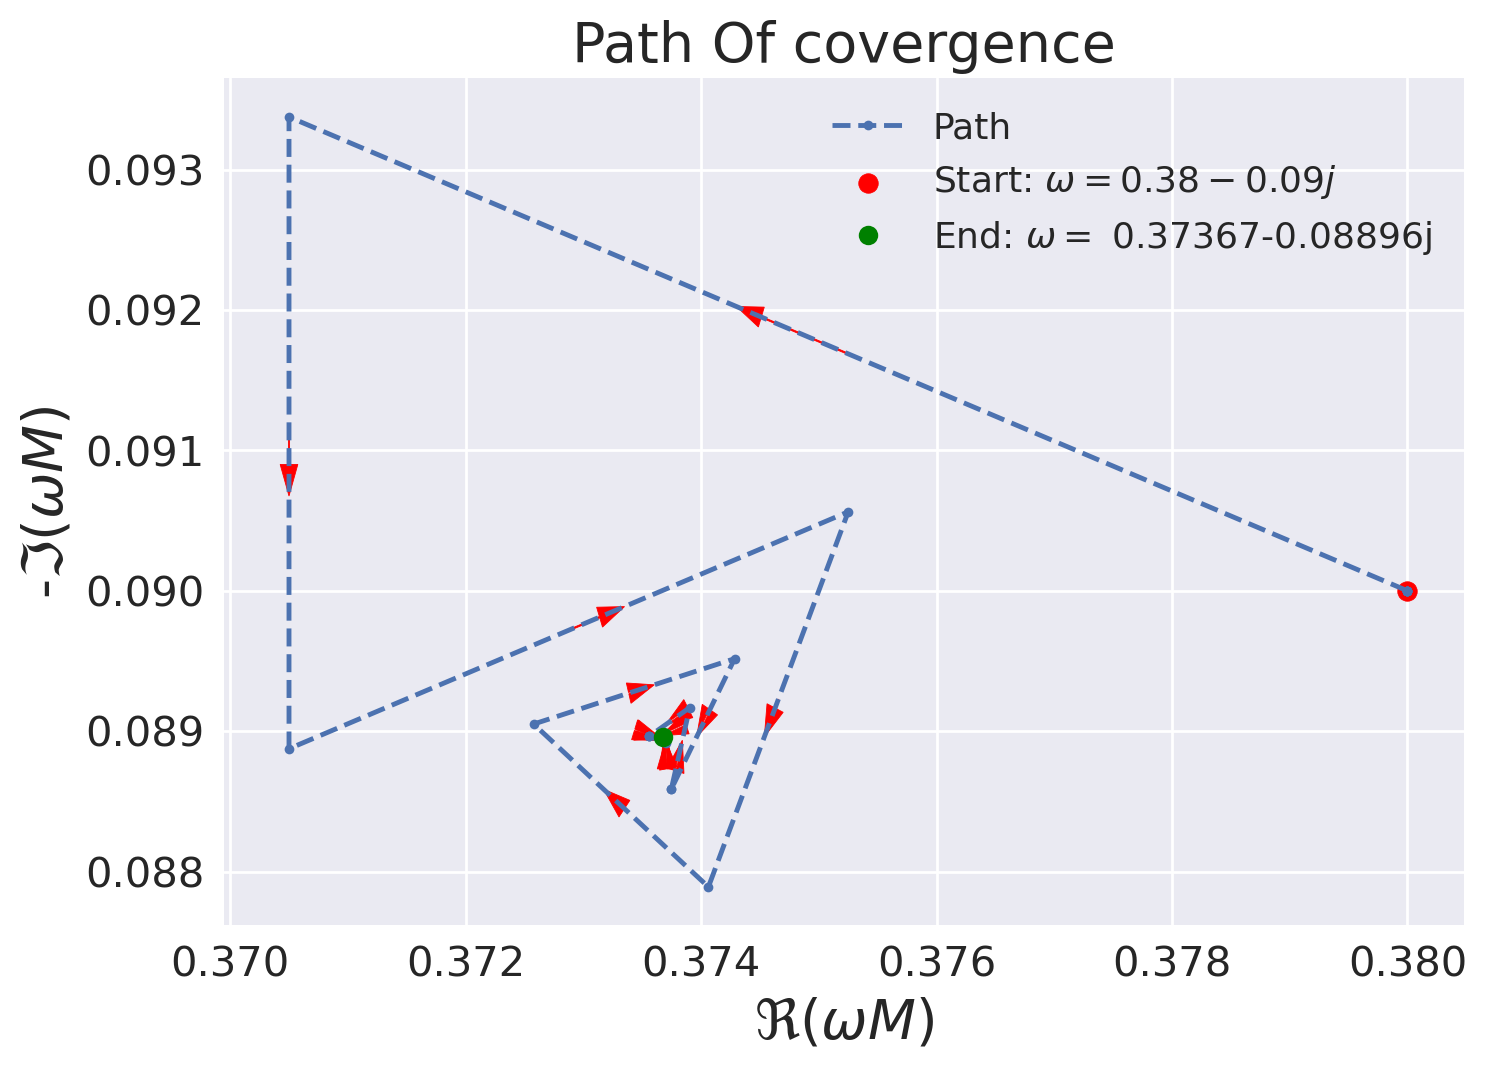

In [11]:
path = np.append(w_start[:2], path)
plt.style.use("seaborn")
# Create fig
fig, ax = plt.subplots()
ax.set_xlabel("$\Re(\omega M)$", size = 20)
ax.set_ylabel("-$\Im(\omega M)$", size = 20)
plt.title("Path Of covergence", size = 20)

# plot data
ax.plot(path[::2],-path[1::2], ".--", label = "Path")
for i in range(1,len(path[::2][:-24])):
    x = (path[::2][i]+path[::2][i-1])/2
    y = -(path[1::2][i]+path[1::2][i-1])/2
    dx = (path[::2][i]-path[::2][i-1])/10
    dy = (-path[1::2][i]+path[1::2][i-1])/10
    ax.arrow(x,y,dx,dy, length_includes_head = True, head_width = 0.00015, width = 0.00001, color = "red")
ax.scatter([w_start[0]],[-w_start[1]], color = "red", label = "Start: $\omega=0.38 - 0.09j$")
ax.plot([path[::2][-1]], [-path[1::2][-1]],"o", color = "green", label = f"End: $\omega=${path[::2][-1] + path[1::2][-1]*1j: .5f}")

ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 13)

(0.0889, 0.089)

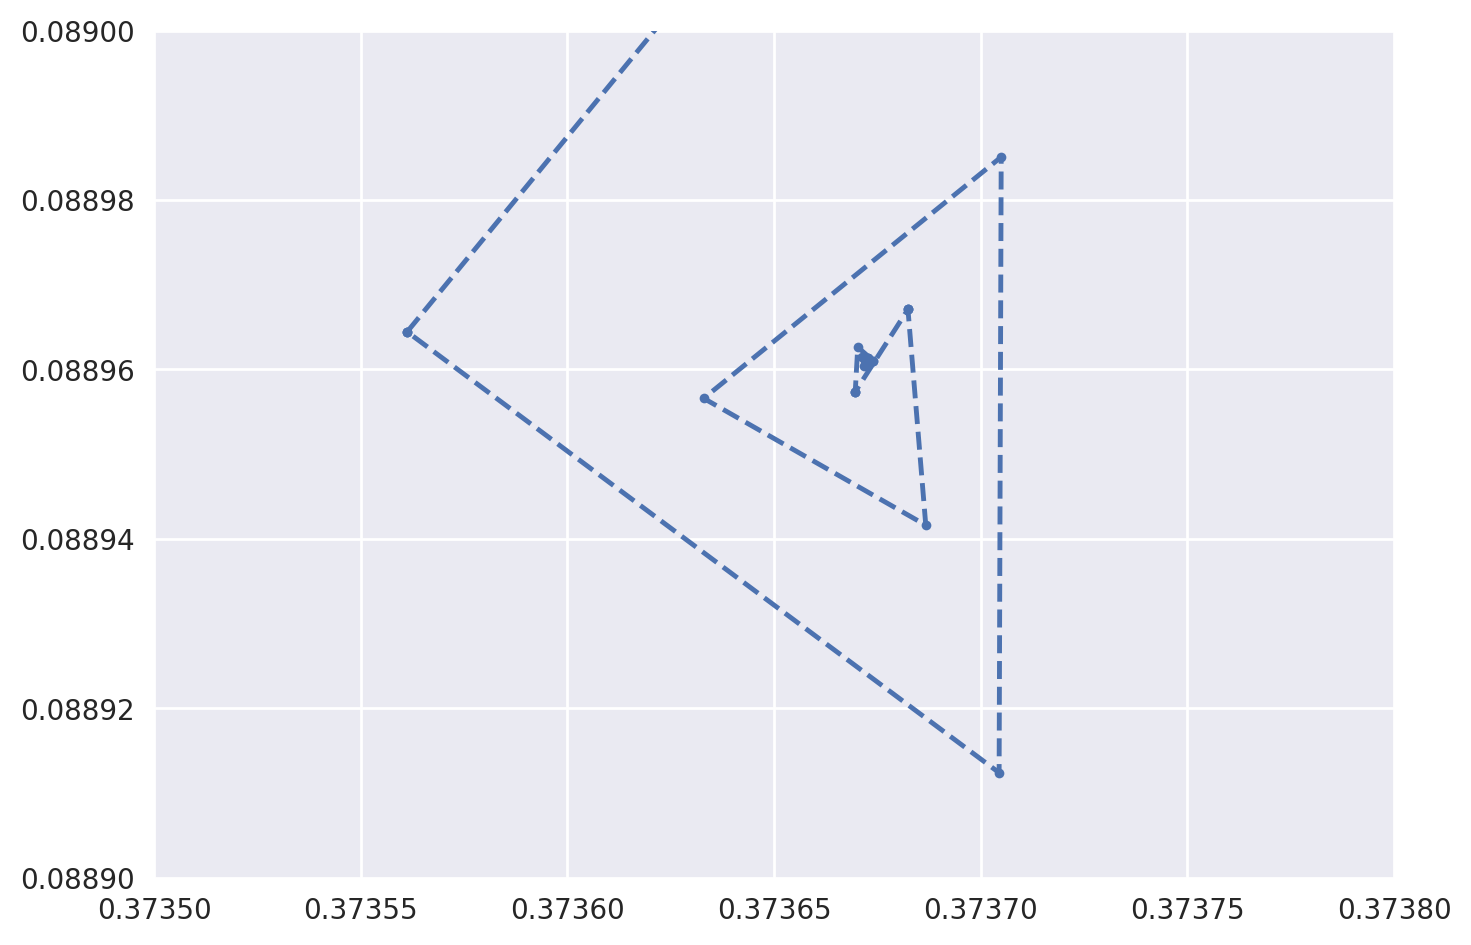

In [35]:
plt.plot(path[::2],-path[1::2], ".--", label = "Path")
plt.scatter([w_start[0]],[-w_start[1]])
plt.xlim(0.3735, 0.3738)
plt.ylim(0.0889, 0.089)

In [11]:
s1_QNMs = np.array(s1_QNMs)
np.savetxt("s1_data.csv", s1_QNMs, delimiter=",")

In [15]:
QNM_s0_quess = np.array([
    [0.48, -0.09, 2, 0],#l=2
    [0.46, -0.29, 2, 0],
    [0.43, -0.51, 2, 0],
    [0.42, -0.72, 2, 0],
    [0.67, -0.09, 3, 0],#l=3
    [0.63, -0.29, 3, 0],
    [0.61, -0.51, 3, 0],
    [0.59, -0.72, 3, 0],
    [0.86, -0.09, 4, 0],#l=4
    [0.84, -0.29, 4, 0],
    [0.80, -0.51, 4, 0],
    [0.78, -0.72, 4, 0]
])

s0_QNMs = []

for i in tqdm(range(len(QNM_s0_quess))):
    H = minimize(QNM_search, np.array([QNM_s0_quess[i][0], QNM_s0_quess[i][1]]), args=(QNM_s0_quess[i][2],QNM_s0_quess[i][3],), method="Nelder-Mead", tol=1e-7).x
    s0_QNMs.append(H)

100%|██████████| 12/12 [16:02<00:00, 80.22s/it] 


In [23]:
s0_QNMs = np.array(s0_QNMs)
np.savetxt("s0_data.csv", s0_QNMs, delimiter=",")

In [6]:
# [w, l, s]
QNM_guess = np.array([
    [0.373 - 0.088j, 2, 2], #l = 2
    [0.346 - 0.273j, 2, 2],
    [0.301 - 0.478j, 2, 2],
    [0.251 - 0.705j, 2, 2],
    [0.599 - 0.092j, 3, 2], #l = 3
    [0.582 - 0.281j, 3, 2],
    [0.551 - 0.479j, 3, 2],
    [0.511 - 0.690j, 3, 2],
    [0.809 - 0.094j, 4, 2], #l = 4
    [0.796 - 0.284j, 4, 2],
    [0.772 - 0.479j, 4, 2],
    [0.739 - 0.683j, 4, 2]
], dtype = np.complex128)

Calc_freq = []
for i in range(len(QNM_guess)):
    Calc_freq.append(minimize(QNM_search, np.array([QNM_guess[i,0].real, QNM_guess[i,0].imag]), args = (QNM_guess[i,1].real,QNM_guess[i,2].real,),method='Nelder-Mead', tol=0.00001).x)

In [7]:
np.savetxt("data.csv",Calc_freq, delimiter=",")

In [6]:
def excitation_factor(QNM, l, s):
    w = QNM
    beta = - np.angle(w)
    # Contour integration path
    rho_min = -50*M
    rho_max = 20000*M

    rmaching = 3*M

    r_sol_left = solve_ivp(drdrho, [0, rho_min], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", rtol = 1e-10, atol = 1e-10)

    r_sol_right = solve_ivp(drdrho, [0, rho_max], np.array([rmaching],dtype = np.complex128),args=(w,), method="DOP853", rtol = 1e-10, atol = 1e-10)

    r_left = r_sol_left.y[0][::-1]
    rho_left = r_sol_left.t[::-1]

    r_right = r_sol_right.y[0][::-1]
    rho_right = r_sol_right.t[::-1]
    
    # Interpolate r and rho
    left_r_rho_interp = interp1d(rho_left, r_left, kind='cubic')
    right_r_rho_interp = interp1d(rho_right, r_right, kind='cubic')
    
    # Inital conditions for left solution
    IC_PL = -1j*np.sqrt(Q(left_r_rho_interp(rho_min), w, l, s))
    IC_HL = -w/IC_PL
    pos_in_left = np.array([IC_PL, IC_HL])

    # Initial conditions for plus/minus solutions
    PP_0 = 1j*np.sqrt(Q(right_r_rho_interp(rho_max), w, l, s))
    IC_HP = -w/PP_0
    IC_IP = 0
    IC_PP = -w*((rmaching+2*np.log(rmaching/2 - 1)) + rho_max*np.exp(1j*beta))-0.5j*np.log((1j*PP_0-w)/(1j*PP_0+w))
    pos_in_plus = np.array([IC_PP, IC_HP, IC_IP])

    PM_0 = -1j*np.sqrt(Q(right_r_rho_interp(rho_max), w, l, s))
    IC_HM = -w/PM_0
    IC_IM = 0
    IC_PM = -w*((rmaching+2*np.log(rmaching/2 - 1)) + rho_max*np.exp(1j*beta))-0.5j*np.log((1j*PM_0-w)/(1j*PM_0+w))
    pos_in_minus = np.array([IC_PM, IC_HM, IC_IM])
    
    # Integrate equations
    # Left solution
    left_sol = solve_ivp(F_left_ma, [rho_left[0],rho_left[-1]], pos_in_left, args=(w,l,s,left_r_rho_interp), t_eval=rho_left, method="DOP853", rtol = 1e-10, atol = 1e-10)
    #left_sol = solver(rho_left, F_left_ma, pos_in_left, w, l, s, left_r_rho_interp)

    # plus, and minus solution
    plus_sol = solve_ivp(F_right_ma, [rho_right[0], rho_right[-1]], pos_in_plus, args=(w,l,s,right_r_rho_interp), t_eval=rho_right, method="DOP853", rtol = 1e-10, atol = 1e-10)

    #plus_sol = solver(rho_right, F_right_ma, pos_in_plus, w, l, s, right_r_rho_interp)
    minus_sol = solve_ivp(F_right_ma, [rho_right[0], rho_right[-1]], pos_in_minus, args=(w,l,s,right_r_rho_interp), t_eval=rho_right, method="DOP853", rtol = 1e-10, atol = 1e-10)

    #minus_sol = solver(rho_right, F_right_ma, pos_in_minus, w, l, s, right_r_rho_interp)
    print('Done!!!!')
    # Q integral
    integral = -(1/right_r_rho_interp(rho_max))*(0.5j/np.sqrt(Q(right_r_rho_interp(rho_max),w,l,s)))*(d2Qdr(right_r_rho_interp(rho_max),l,s))
    
    HP = plus_sol.y[1][-1]
    HL = left_sol.y[1][-1]
    DHPHL = HP-HL

    PL = left_sol.y[0][-1]
    PM = from_prufer(minus_sol.y[0], rho_right, w)[-1]
    DPLPM = PL - PM

    Theta = plus_sol.y[2][-1]-minus_sol.y[2][-1] + 2j*w*(rmaching + 2*np.log(rmaching/2 - 1)+ rho_max*np.exp(1j*beta)) + integral
    
    frac = (DHPHL/DPLPM)*np.exp(Theta)
    BN = 1/(2*w*frac)
    print("Excitation factor")
    print("-----------------")
    print(f"w: {w}")
    print(f"Bn: {BN}")
    print(f"l = {l}, s = {s}")
    print("-----------------")
    return BN

In [18]:
s0_data = pd.read_csv("s0_data.csv")

QNEF_s0 = []

for i in range(len(s0_data["l"])):
    QQQ = excitation_factor(s0_data["Re(w)"][i]+1j*s0_data["Im(w)"][i], s0_data["l"][i], s0_data["s"][i])
    QNEF_s0.append(QQQ)
    clear_output(wait = True)

Done!!!!
Excitation factor
-----------------
w: (0.8032725811838644-0.6974795528090536j)
Bn: (-0.29046825581058616+0.9678878430425243j)
l = 4, s = 0
-----------------


In [21]:
QNEF_s0 = np.array(QNEF_s0)
np.savetxt("s0_QNEF.csv",QNEF_s0)
QNEF_s0

array([ 0.11934812+0.01350409j,  0.03567101-0.26425967j,
       -0.28611483+0.04580559j,  0.16206748+0.15716818j,
       -0.09359873-0.04055235j, -0.13436299+0.29405678j,
        0.4878057 +0.12077692j, -0.092361  -0.51735419j,
        0.06798492+0.05920259j,  0.24790979-0.2751801j ,
       -0.62053665-0.42185215j, -0.29046826+0.96788784j])

In [13]:
s1_data = pd.read_csv("s1_data.csv")

QNEF_s1 = []

for i in range(len(s1_data["l"])):
    QQQ = excitation_factor(s1_data["Re(w)"][i]+1j*s1_data["Im(w)"][i], s1_data["l"][i], s1_data["s"][i])
    QNEF_s1.append(QQQ)
    clear_output(wait = True)

Done!!!!
Excitation factor
-----------------
w: (0.7877332719065168-0.6942325269234144j)
Bn: (-0.3031141266665127+0.9375212772670656j)
l = 4, s = 1
-----------------


In [14]:
QNEF_s1 = np.array(QNEF_s1)
np.savetxt("s1_QNEF.csv",QNEF_s1)
QNEF_s1

array([ 0.12117702+0.01871804j,  0.04677953-0.25893673j,
       -0.27295943+0.03238435j,  0.14477497+0.14702579j,
       -0.09339608-0.04361196j, -0.14213668+0.28821926j,
        0.47244963+0.13181276j, -0.07570251-0.49728839j,
        0.06711715+0.06103143j,  0.25308215-0.26868195j,
       -0.60249749-0.42970852j, -0.30311413+0.93752128j])

In [12]:
def QNEF_from_guess(QNM_guess, l, s):
    rho_min = -50*M
    rho_max = 7000*M
    print("Calculating QNM frequency")
    w_cal = minimize(QNM_search, np.array([QNM_guess.real, QNM_guess.imag]), args=(l, s,),method='Nelder-Mead', tol=0.0001)
    QNM = w_cal.x[0] + w_cal.x[1]*1j
    print("Calculating QNEF")
    BN = excitation_factor(QNM, l, s)
    clear_output(wait=True)
    return QNM, BN

In [9]:
df = pd.read_csv("data.csv")

In [10]:
QNEF_Calc = []

for i in tqdm(range(len(df["Re(w)"]))):
    w = df["Re(w)"][i]+df["Im(w)"][i]*1j
    l = df["l"][i]
    s = df["s"][i]
    QEF = excitation_factor(w, l, s)
    QNEF_Calc.append([QEF.real, QEF.imag])
    clear_output(wait=True)

100%|██████████| 12/12 [01:21<00:00,  6.81s/it]


In [11]:
np.savetxt("QNEF.csv",QNEF_Calc, delimiter=",")

In [112]:
QNMs = np.array([
    [0.373672-0.088962j, 2, 2],
    [0.346711-0.273915j, 2, 2],
    [0.301052-0.478276j, 2, 2],
    [0.251504-0.705148j, 2, 2]
    []
])
import threading
QNEFs = np.array([])

def saver_QNEF(arg):
    global QNEFs
    BN = excitation_factor(*arg)
    QNEFs = np.append(QNEFs, BN)

threds = list()
for i in range(len(QNMs)):
    x = threading.Thread(target = saver_QNEF, args = (QNMs[i],))
    threds.append(x)
    x.start()
    clear_output(wait=True)

for th in threds:
    th.join()

right
Solving for the plus solution
right
Solving for the left solutions
right
Solving for the left solutions
Solving for the left solutions
Solving for the plus solution
Solving for the plus solution
Solving for the plus solution
Solving for the minus solution
Solving for the minus solution
Solving for the minus solution
Solving for the minus solution
Done!!!!
Excitation factor
-----------------
w: (0.373672-0.088962j)
Bn: (0.12685814611165158+0.02060015554145466j)
l = (2+0j), s = (2+0j)
-----------------


<ipython-input-5-cdc17c697cdd>:64: RuntimeWarning: overflow encountered in exp
  A = np.exp(2j*(w*rs+Pt[i]))
<ipython-input-5-cdc17c697cdd>:65: RuntimeWarning: invalid value encountered in scalar multiply
  PPP[i] = 1j*w*(A+1)/(A-1)
<ipython-input-5-cdc17c697cdd>:65: RuntimeWarning: invalid value encountered in scalar divide
  PPP[i] = 1j*w*(A+1)/(A-1)


Done!!!!
Excitation factor
-----------------
w: (0.346711-0.273915j)
Bn: (0.048123810724503426-0.22365671107084228j)
l = (2+0j), s = (2+0j)
-----------------
Done!!!!
Excitation factor
-----------------
w: (0.251504-0.705148j)
Bn: (0.08078229789139625+0.07970880151070528j)
l = (2+0j), s = (2+0j)
-----------------
Done!!!!
Excitation factor
-----------------
w: (0.301052-0.478276j)
Bn: (-0.19031121217791663+0.015467322714547616j)
l = (2+0j), s = (2+0j)
-----------------


In [27]:
QNM_G = 0.4 - 0.1j
QNM_R = 0.373672 - 0.088962j
PL_G, PP_G = sol(QNM_G, 2, 2)
PL_R, PP_R = sol(QNM_R, 2, 2)

PPy_G = from_prufer(PP_G.y[0], PP_G.t, QNM_G)
PPy_R = from_prufer(PP_R.y[0], PP_R.t, QNM_R)

<ipython-input-2-451a713bfd39>:75: RuntimeWarning: overflow encountered in exp
<ipython-input-2-451a713bfd39>:76: RuntimeWarning: invalid value encountered in scalar multiply
<ipython-input-2-451a713bfd39>:76: RuntimeWarning: invalid value encountered in scalar divide
<ipython-input-2-451a713bfd39>:76: RuntimeWarning: overflow encountered in scalar divide


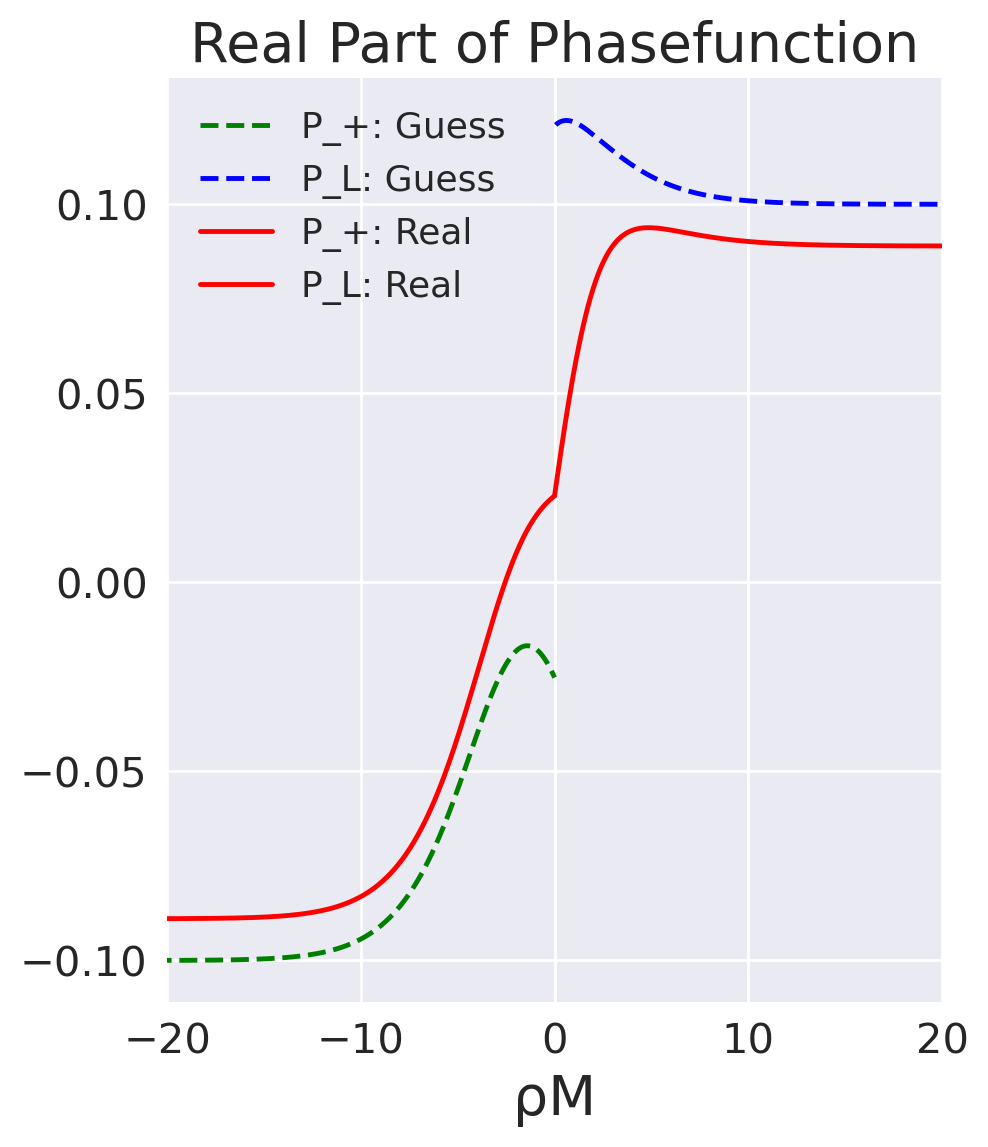

In [41]:
plt.style.use("seaborn")
plt.figure(figsize = (5,6))
plt.title("Real Part of Phasefunction", size = 20)
plt.xlabel("ρM", size = 20)

# Guess plot
plt.plot(PL_G.t, PL_G.y[0].real,"--", label = "P_+: Guess", color = "Green")
plt.plot(PP_G.t, PPy_G.real,"--", label = "P_L: Guess", color = "blue")

# Real plot
plt.plot()
plt.plot(PL_R.t, PL_R.y[0].real,"-", label = "P_+: Real", color = "red")
plt.plot(PP_R.t, PPy_R.real,"-", label = "P_L: Real", color = "red")

plt.xlim(-20,20)
plt.legend(fontsize = 13, loc = "upper left")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)